### **Waze Predicitve Model Project**

##### **The purpose of this project is to conduct a study of sample user data to gain insight into what factors lead to user disconinuance (churn) of utilizing the Waze app. This project is based on my practice-based learning while completing the 7 courses of the Google Advanced Data Analytics Certificate. The project covers the processes of EDA, data visualization, hypothesis testing, regression analysis, and tree-based analysis using decision tree and random forest machine learning models. The data is fictitious, and was provided by the Certificate courses.**

##### **The analytic framework of this project is based on the PACE workflow model. PACE (Plan, Analyize, Construct, Execute) is the workflow model utilized throughout Google's Advanced Analytics Certificate. I have subdivided this notebook based on these 4 stages of this framework.**

### **PACE: Plan**

#### **The purpose** of this project is to find factors that drive user churn.

#### **The goal** of this projectis to predict whether a Waze user is retained or churned.

#### **Do we have adequate data to conduct a worthwhile study, and create predictive models?**

#### We have a sample dataset in a tabular csv format, created by the data engineering team. The team has done well for us in the past, therefore there is strong reason to believe they have done an excellent job again. More answers to this question will be gained through EDA and visaulizations.  

#### **If a machine learning model is created, what is the likely effect of the model when it predicts a false negative (when the model says a user won't churn, but they will)?**

#### Waze will fail to take proactive measures to retain users who are likely to stop using the app. For example, Waze might proactively push an app notification to users, or send a survey to better understand user dissatisfaction.

#### **If a machine learning model is created, what is the likely effect of the model when it predicts a false positive (when the model says a Waze user will churn, but they won't)?**

#### Waze may take proactive measures to retain users who are NOT likely to churn. This may lead to an annoying or negative experience for loyal users of the app.

#### **Do the benefits of creating a model outweigh the potential problems?**

#### The proactive measueres taken by Waze might have unintended effects on users, and these effects might encourage user churn. Follow-up analysis on the effectiveness of the measures is recommended. If the measures are reasonable and effective, then the benefits will most likely outweigh the problems.

#### **Is it in the best interest of the business to proceed with the leadership's request to conduct this study, and build the models?** 

#### Yes. There aren't any significant risks for conducting this study and building such a model.

#### **Step 1: Imports and data loading.**

In [1]:
# Packages for data manipulation
import numpy as np
import pandas as pd

# Packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set option to see all columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Package for hypothesis testing
from scipy import stats

# Packages for data modeling and metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay 

# Packages for ML classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

In [3]:
# Load dataset
df0 = pd.read_csv('waze_dataset.csv')

### **PACE: Analyze**

### **Step 2: Data Cleaning and Exploration**

#### **Step 2a: Data Cleaning**

In [227]:
# Display info
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


##### **We see from the info() display above that we are missing values in the 'label' column in 700 rows of the data. I will examine this further.**

In [7]:
# Display info for df0
df0.isna().sum()

ID                           0
label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64

In [7]:
# Isolate rows without null values
not_null_df0 = df0[~df0['label'].isnull()]

In [8]:
# Check the not_null_df0 dataframe
not_null_df0.isna().sum()

ID                         0
label                      0
sessions                   0
drives                     0
total_sessions             0
n_days_after_onboarding    0
total_navigations_fav1     0
total_navigations_fav2     0
driven_km_drives           0
duration_minutes_drives    0
activity_days              0
driving_days               0
device                     0
dtype: int64

In [9]:
# Isolate rows with null values
null_df0 = df0[df0['label'].isnull()]

In [10]:
# Check the null_df0 dataframe
null_df0.isna().sum()

ID                           0
label                      700
sessions                     0
drives                       0
total_sessions               0
n_days_after_onboarding      0
total_navigations_fav1       0
total_navigations_fav2       0
driven_km_drives             0
duration_minutes_drives      0
activity_days                0
driving_days                 0
device                       0
dtype: int64

In [12]:
# Display number of iPhone and Android users that had null values in 'label' column
null_df0['device'].value_counts()

device
iPhone     447
Android    253
Name: count, dtype: int64

In [13]:
# Display percentage of iPhone and Android users that had null values in 'label' column
null_df0['device'].value_counts(normalize=True)

device
iPhone     0.638571
Android    0.361429
Name: proportion, dtype: float64

In [14]:
# Show how this compares to the device ratio in the full dataset
df0['device'].value_counts(normalize=True)

device
iPhone     0.644843
Android    0.355157
Name: proportion, dtype: float64

##### **We see from the above that the number of retained vs churned users is roughly the same for both the rows with null values in the 'label' column, and the rows without null values in 'label' (~64% iPhone and ~36% Android).** 

#### **Step 2b: Exploratory Data Analysis**

In [15]:
# Examine the counts and percentages of users who churned vs. retained. 
print(df0['label'].value_counts())
print()
print(df0['label'].value_counts(normalize=True))

label
retained    11763
churned      2536
Name: count, dtype: int64

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64


##### **Roughly 82% of users stayed with the app, and about 18% of users churned.**

In [16]:
# Calculate median values of all columns for churned and retained users
df0.groupby('label').median(numeric_only=True)

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
label,,,,,,,,,,,
churned,7477.5,59.0,50.0,164.339042,1321.0,84.5,11.0,3652.655666,1607.183785,8.0,6.0
retained,7509.0,56.0,47.0,157.586756,1843.0,68.0,9.0,3464.684614,1458.046141,17.0,14.0


In [17]:
# Calculate the median kilometers per drive in the last month for ret and churned users.
medians_by_label = df0.groupby('label').median(numeric_only=True)
print('Median kilometers per drive:')
medians_by_label['driven_km_drives'] / medians_by_label['drives']

Median kilometers per drive:


label
churned     73.053113
retained    73.716694
dtype: float64

##### The median distance users from both groups drove is ~73 km/drive. 

In [19]:
# Determine how many kilometers per driving day this was.
# Divide the median distance by median number of driving days
print('Median kilometers per driving day:')
medians_by_label['driven_km_drives'] / medians_by_label['driving_days']

Median kilometers per driving day:


label
churned     608.775944
retained    247.477472
dtype: float64

##### **Here we see that users who churned drove 608 km per day, but those who did not churn drove around 247 km per day.**

In [20]:
# Calculate the median number of drives per driving day for each group.
# Divide the median number of drives by median number of driving days
print('Median drives per driving day:')
medians_by_label['drives'] / medians_by_label['driving_days']

Median drives per driving day:


label
churned     8.333333
retained    3.357143
dtype: float64

##### **This shows us that median of users who churned drove around 8 times per day, but the median of those who did not churn drove about 3 times per day.**

In [21]:
# Examine whether there is an imbalance in how many users churned by device type.
print('Checking class balance: Number of users who churned and stayed by device type')
df0.groupby(['label', 'device']).size()

Checking class balance: Number of users who churned and stayed by device type


label     device 
churned   Android     891
          iPhone     1645
retained  Android    4183
          iPhone     7580
dtype: int64

In [22]:
# Display percentage of users who churned and stayed by device type
print('Number of users who churned and stayed by device type')
df0.groupby('label')['device'].value_counts(normalize=True)

Number of users who churned and stayed by device type


label     device 
churned   iPhone     0.648659
          Android    0.351341
retained  iPhone     0.644393
          Android    0.355607
Name: proportion, dtype: float64

##### **We see here that roughly twice as many iPhone users both chruned and stayed with the app.**
##### **What we see overall from the EDA above is that although median distance driven by churned and retained users is roughly 73 km, churned users drove further and more often than retained users.**

### **Step 3. Visualizations**

#### **Step 3a: Variable distributions**

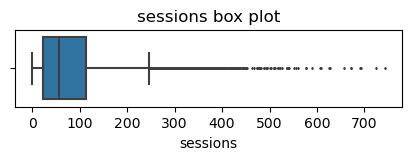

In [24]:
# Box plot of 'sessions' variable
plt.figure(figsize=(5,1))
sns.boxplot(x=df0['sessions'], fliersize=1)
plt.title('sessions box plot');

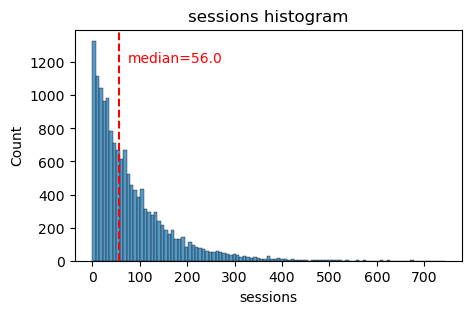

In [25]:
# Histogram of the 'sessions' variable
plt.figure(figsize=(5,3))
sns.histplot(x=df0['sessions'])
median = df0['sessions'].median()
plt.axvline(median, color='red', linestyle='--')
plt.text(75,1200, 'median=56.0', color='red')
plt.title('sessions histogram');

##### **The sessions variable is a right-skewed distribution with half of the observations having 56 or fewer sessions. However, as indicated by the boxplot, some users have more than 700.**

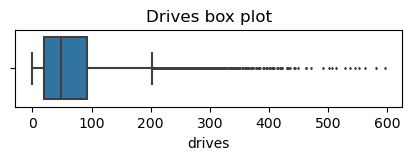

In [27]:
# Box plot of 'drives' variable
plt.figure(figsize=(5,1))
sns.boxplot(x=df0['drives'], fliersize=1)
plt.title('Drives box plot');

#### **Here we see that the 'drives' variable appears to have a median of 50 drives, and several outliers above 450 drives.**

##### **The following function assits in plotting histograms with a particular style and format that is useful int his project. This helps reduce repetitive code.**

In [30]:
# Helper function to plot histograms based on the format of the `sessions` histogram
def plot_histogram(column_str, median_text=True, **kwargs): 
    median=round(df0[column_str].median(), 1)
    plt.figure(figsize=(5,3))
    ax = sns.histplot(x=df0[column_str], **kwargs)    # Plot the histogram
    plt.axvline(median, color='red', linestyle='--')  # Plot the median line
    if median_text==True:                             # Add median text unless set to False
        ax.text(0.25, 0.85, f'median={median}', color='red',
            ha='left', va='top', transform=ax.transAxes)
    else:
        print('Median:', median)
    plt.title(f'{column_str} histogram');

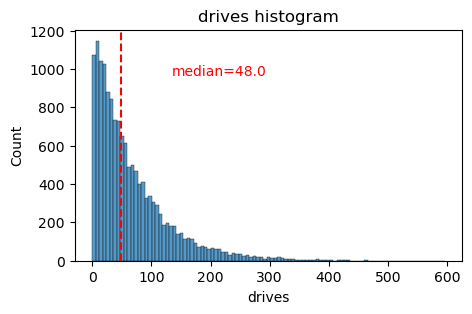

In [31]:
# Histogram of 'drives' variable
plot_histogram('drives')

##### **The drives variable follows a similar distribution to the sessions variable. It is right-skewed, approximately log-normal, with a median of 48. As with the boxplot, we see the outlying values above 400 and 500 drives.** 

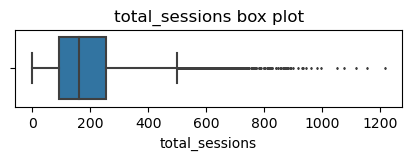

In [33]:
# Box plot of 'total sessions'
plt.figure(figsize=(5,1))
sns.boxplot(x=df0['total_sessions'], fliersize=1)
plt.title('total_sessions box plot');

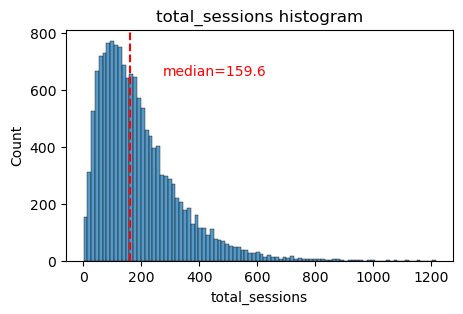

In [34]:
# Histogram of 'total sessions'
plot_histogram('total_sessions')

##### **The total_sessions is a right-skewed distribution. The median total number of sessions is 159.6. This is important because, if the median number of sessions in the last month was 56 and the median total sessions was ~160, then it seems apparent that a large proportion of a user's estimated total drives might have taken place in the last month.** 

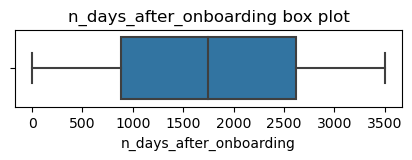

In [36]:
# Box plot of n_days_since_onboarding
plt.figure(figsize=(5,1))
sns.boxplot(x=df0['n_days_after_onboarding'], fliersize=1)
plt.title('n_days_after_onboarding box plot');

Median: 1741.0


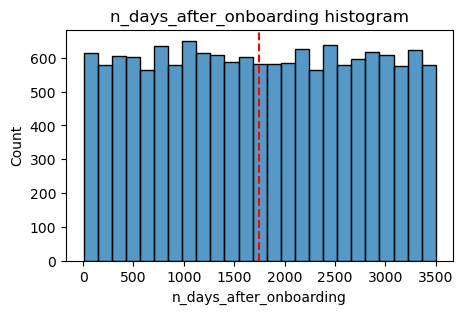

In [37]:
# Histogram of 'n_days_after_onbarding'
plot_histogram('n_days_after_onboarding', median_text=False)

##### **The number of days since onboarding is a uniform distribution with values ranging from near zero to around 3,500 (~9.5 years).**

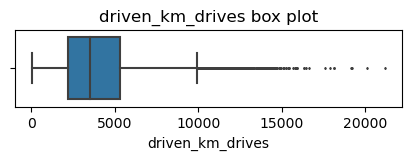

In [39]:
# Box plot of 'driven_km_drives'
plt.figure(figsize=(5,1))
sns.boxplot(x=df0['driven_km_drives'], fliersize=1)
plt.title('driven_km_drives box plot');

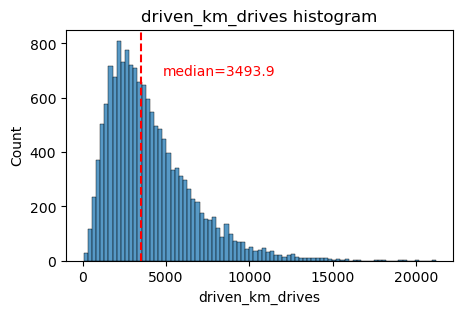

In [40]:
# Histogram of 'driven_km_drives'
plot_histogram('driven_km_drives')

##### **The number of kilometers driven in the last month per user is a right-skewed distribution with half the users driving under 3,495 kilometers (2,172 miles). We see here that the users in this dataset drive a lot.** 

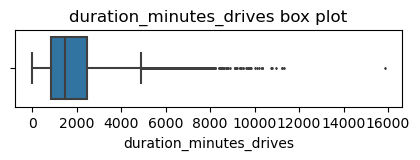

In [42]:
# Box plot 'duration_minutes_drives'
plt.figure(figsize=(5,1))
sns.boxplot(x=df0['duration_minutes_drives'], fliersize=1)
plt.title('duration_minutes_drives box plot');


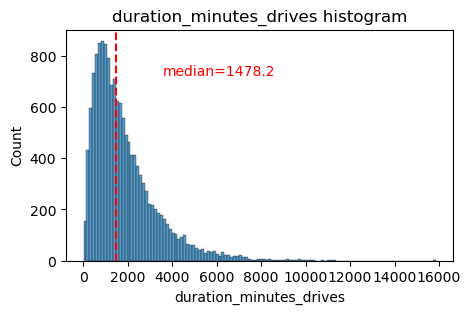

In [43]:
# Histogram of 'duration_minutes_drives'
plot_histogram('duration_minutes_drives')

##### **The duration_minutes_drives variable has a heavily skewed right tail. Half of the users drove less than ~ 1,478 minutes (~ 25 hours), but some users clocked over 250 hours during the month.**

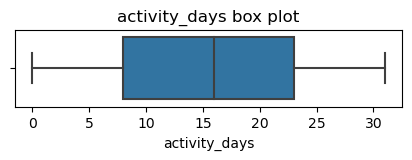

In [45]:
# Box plot of 'activity_days'
plt.figure(figsize=(5,1))
sns.boxplot(x=df0['activity_days'], fliersize=1)
plt.title('activity_days box plot');


Median: 16.0


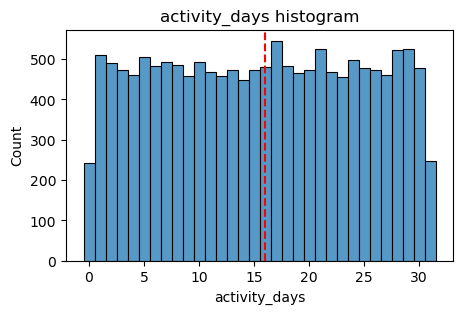

In [46]:
# Histogram of 'activity_days'
plot_histogram('activity_days', median_text=False, discrete=True)

##### **Within the last month, users opened the app a median of 16 times. The box plot reveals a centered distribution. The histogram shows a nearly uniform distribution of ~500 people opening the app on each count of days. However, there are ~250 people who didn't open the app at all and ~250 people who opened the app every day of the month. This distribution is interesting because it does not mirror the sessions distribution, which it seems to me would have been closely correlated with activity_days.**


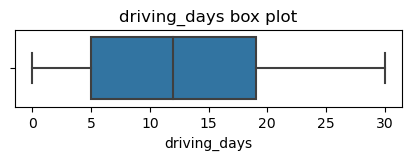

In [48]:
# Box plot of 'drving_days'
plt.figure(figsize=(5,1))
sns.boxplot(x=df0['driving_days'], fliersize=1)
plt.title('driving_days box plot');

Median: 12.0


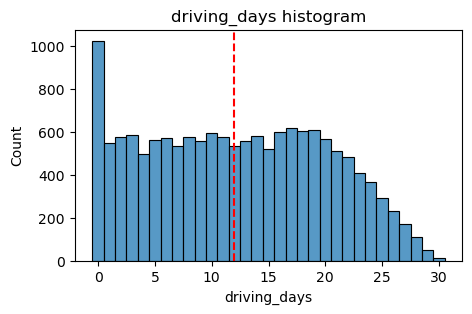

In [49]:
# Histogram of 'driving_days'
plot_histogram('driving_days', median_text=False, discrete=True)

##### **The number of days users drove at least 1 km during the month is almost uniform, and it largely correlates with the number of days they opened the app that month, except the driving_days distribution tails off on the right. However, there were almost twice as many users (~1,000) who did not drive at all during the month. This might seem counterintuitive when considered with activity_days, which showed ~250 users did not open the app at all during the month. This discrepancy might deserve further thought.**


#### **User by device (iPhone and Android).**

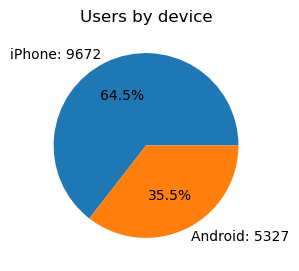

In [51]:
# Pie chart of user by 'device'
fig = plt.figure(figsize=(3,3))
data=df0['device'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Users by device');

#### **Retained vs chruned users.**

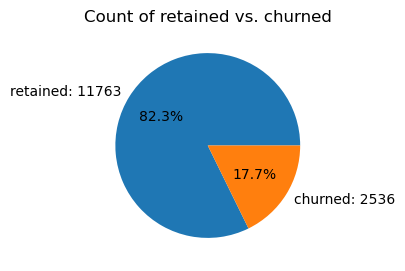

In [52]:
# Pie chart of 'label' (retained vc churned users)
fig = plt.figure(figsize=(3,3))
data=df0['label'].value_counts()
plt.pie(data,
        labels=[f'{data.index[0]}: {data.values[0]}',
                f'{data.index[1]}: {data.values[1]}'],
        autopct='%1.1f%%'
        )
plt.title('Count of retained vs. churned');

#### **Step 3b: Variable relationships.**

#### **driving_days vs activity_days.**

In [9]:
# Confirm the maximum number of days for each variable, driving_days and activity_days.
print('Maximum of driving_days:  ', df0['driving_days'].max())
print('Maximum of activity_days: ', df0['activity_days'].max())

Maximum of driving_days:   30
Maximum of activity_days:  31


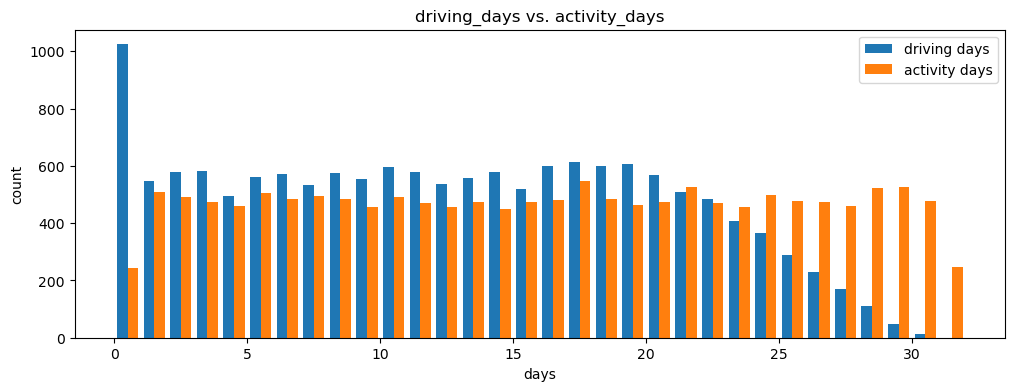

In [53]:
# Histogram 'driving_days' vc 'activity_days'
# This creates one histogram plot with side by side bars (driving_days blue, activity_days orange).
plt.figure(figsize=(12,4))
label=['driving days', 'activity days']
plt.hist([df0['driving_days'], df0['activity_days']],
         bins=range(0,33),
         label=label)
plt.xlabel('days')
plt.ylabel('count')
plt.legend()
plt.title('driving_days vs. activity_days');

##### **This variable relationship might also seems counterintuitive. Nearly two-thirds of the days show that more people drove on a particular day, but opened the app less times on that same day. How could people use the app to drive without opening the app? Perhaps, even though these variables are related to each other, they're not the same. It seems worthwhile to contact the data team to get more information about this, especially because it seems that the number of days in the month is not the same between variables.**

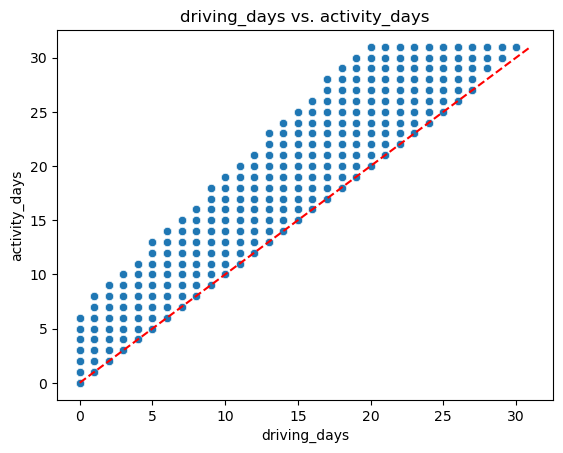

In [55]:
# Scatter plot of 'driving_days vs. activity_days"
# This produces a scatter plot with blue dots increasing upward and to the right, 
# and a red line following this trend).
sns.scatterplot(data=df0, x='driving_days', y='activity_days')
plt.title('driving_days vs. activity_days')
plt.plot([0,31], [0,31], color='red', linestyle='--');

##### **The scatterplot above is encouraging, as we do see driving_days and activity_days roughly correltaed.**

#### **Retention by device.**

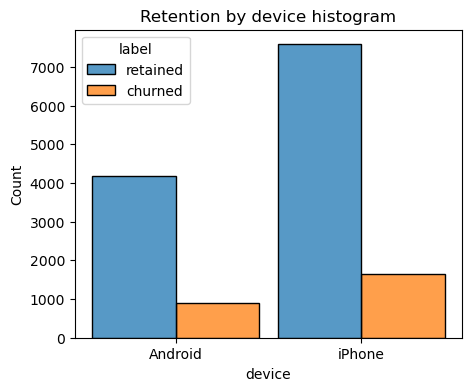

In [56]:
# Histogram of retention by device.
# This produces a histogram with 2 side by side bars for Android, 
# and 2 side by side bars for iPhone.
plt.figure(figsize=(5,4))
sns.histplot(data=df0,
             x='device',
             hue='label',
             multiple='dodge',
             shrink=0.9
             )
plt.title('Retention by device histogram');

##### **The proportion of churned users to retained users is consistent between device types.**

##### **Let's egineer a new variable to use in our visualizations and subsequent analysis. Call the variable 'km_per_driving_day' to refer to the number of kilometers driven per day by each user.**

In [34]:
# Create `km_per_driving_day` column
df0['km_per_driving_day'] = df0['driven_km_drives'] / df0['driving_days']
# Call `describe()` on the new column
df0['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [36]:
# Convert infinite values to zero
df0.loc[df0['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0
# Confirm that it worked
df0['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

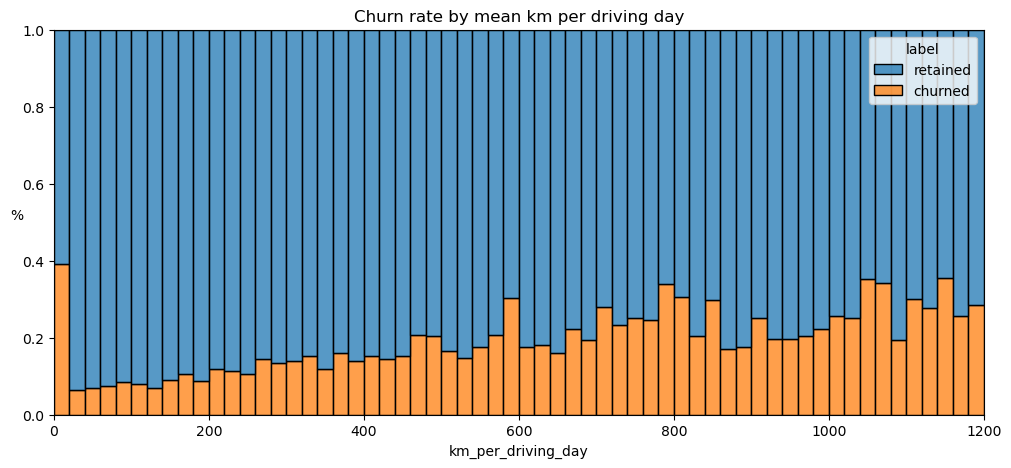

In [59]:
# Histogram of churn rate by mean km per driving day
# This histogram produces a stacked histogram with retained as blue bars uniformly distributed
# at 1.0, and orange bars stacked within representing churned. 
plt.figure(figsize=(12,5))
sns.histplot(data=df0,
             x='km_per_driving_day',
             bins=range(0,1201,20),
             hue='label',
             multiple='fill')
plt.ylabel('%', rotation=0)
plt.title('Churn rate by mean km per driving day');

##### **The 'Churn rate by mean km per driving day' histogram above shows that users who drove further churned more.**

#### **Churn rate per driving day.**

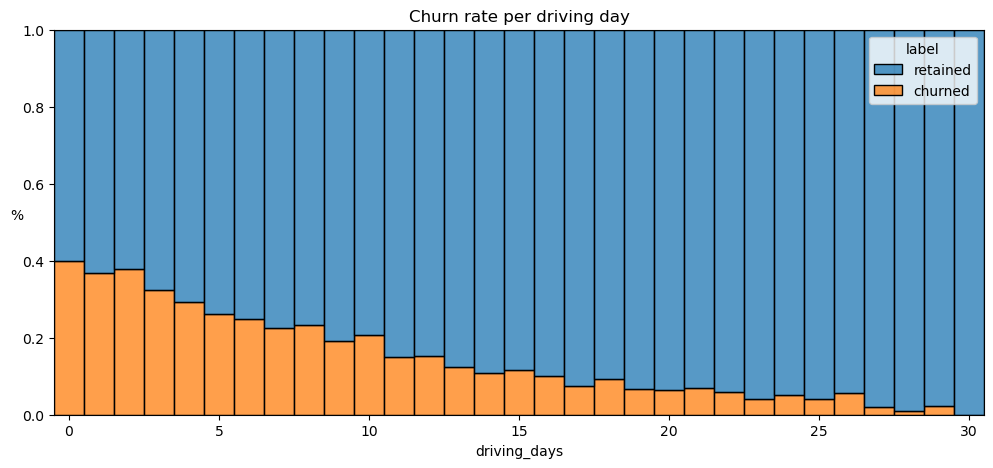

In [60]:
# Histogram of churn rate per driving day
plt.figure(figsize=(12,5))
sns.histplot(data=df0,
             x='driving_days',
             bins=range(1,32),
             hue='label',
             multiple='fill',
             discrete=True)
plt.ylabel('%', rotation=0)
plt.title('Churn rate per driving day');

##### **The 'Churn rate per driving day' histogram above shows that user s churn LESS as the number of days they drove during the last month increased. This appears a little odd to what has been seen so far.** 

##### **Let's engineer another variable, 'percent_sessions_in_last_month', to reference the percentage of total user sessions that occurred during the past month.**

In [38]:
# Create a new column percent_sessions_in_last_month that represents the percentage of 
# each user's total sessions that were logged in their last month.
df0['percent_sessions_in_last_month'] = df0['sessions'] / df0['total_sessions']
# What is the median value of the new column?
print('Percent of total user sessions in the last month:', df0['percent_sessions_in_last_month'].median())

Percent of total user sessions in the last month: 0.42309702992763176


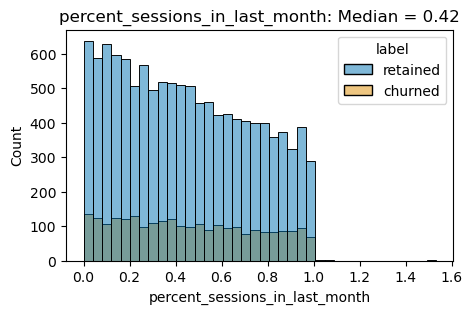

In [26]:
# Histogram of 'percent_sessions_in_last_month'
# This produces a stacked histogram with retained as blue bars, and orange bars stacked
# within representing churned (although showing as grey,
# likely due to the Python environment)
median=round(df0['percent_sessions_in_last_month'].median(), 2)
plt.figure(figsize=(5,3))
sns.histplot(data=df0,
             x='percent_sessions_in_last_month',
             hue=df0['label'],
             multiple='layer',
#             palette=['blue', 'orange'])
             palette='colorblind')
plt.title(f'percent_sessions_in_last_month: Median = {median}');

##### **The median percentage of user sessions in the last month, out of total sessions, is 42%. Although we see the number of user session decrease as this percentage rises, this shows that the data contains a large amount of user sessions in the last month.** 

##### **Check the median value of 'n_days_after_onboarding'.**

In [28]:
# Check the median value of the n_days_after_onboarding variable.
print('Median number of days since onboarding: ', df0['n_days_after_onboarding'].median())

Median number of days since onboarding:  1741.0


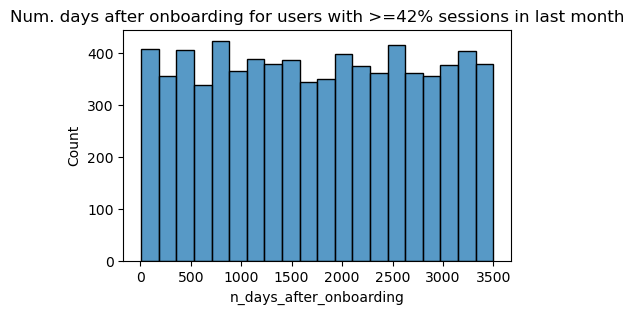

In [30]:
# Histogram of num. days after onboarding for users with >=40% sessions in last month
data = df0.loc[df0['percent_sessions_in_last_month']>=0.42]
plt.figure(figsize=(5,3))
sns.histplot(x=data['n_days_after_onboarding'])
plt.title('Num. days after onboarding for users with >=42% sessions in last month');

##### **Although half of the people in the dataset had 42% or more of their sessions in the last month, the overall median time since onboarding is almost five years. 'n_days_since_onbaording' is a uniform distribution. This is very strange. It's worth asking why so many long-time users suddenly used the app so much in the last month.**


#### **Task 3c. Handling outliers.**

In [41]:
def outlier_imputer(column_name, percentile):
    # Calculate threshold
    threshold = df0[column_name].quantile(percentile)
    # Impute threshold for values > than threshold
    df0.loc[df0[column_name] > threshold, column_name] = threshold
    print('{:>25} | percentile: {} | threshold: {}'.format(column_name, percentile, threshold))

In [43]:
for column in ['sessions', 'drives', 'total_sessions',
               'driven_km_drives', 'duration_minutes_drives']:
               outlier_imputer(column, 0.95)

                 sessions | percentile: 0.95 | threshold: 243.0
                   drives | percentile: 0.95 | threshold: 201.0
           total_sessions | percentile: 0.95 | threshold: 454.3632037399997
         driven_km_drives | percentile: 0.95 | threshold: 8889.7942356
  duration_minutes_drives | percentile: 0.95 | threshold: 4668.899348999998


In [68]:
df0.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,76.568705,64.058204,184.031320,1749.837789,121.605974,29.672512,3939.632764,1789.647426,15.537102,12.179879,578.963113,0.449255
std,4329.982679,67.297958,55.306924,118.600463,1008.513876,148.121544,45.394651,2216.041510,1222.705167,9.004655,7.824036,1030.094384,0.286919
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,136.238895,0.196221
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,272.889272,0.423097
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,558.686918,0.687216
max,14998.000000,243.000000,201.000000,454.363204,3500.000000,1236.000000,415.000000,8889.794236,4668.899349,31.000000,30.000000,15420.234110,1.530637


### Step 4 Hypothesis Testing

In [47]:
# Encode the categorical 'device' column
df0['device_int'] = df0['device'].map({"iPhone": 1, "Android": 2})
df0[['device', 'device_int']].head()

,device,device_int
0,Android,2
1,iPhone,1
2,Android,2
3,iPhone,1
4,Android,2


In [21]:
# Check for 0 values in drives to avoid possible division errors
count_zeros = (df0['drives'] == 0).sum()
print('Number of 0 values in drives column: ', count_zeros)

Number of 0 values in drives column:  106


In [23]:
# Calculate the mean of drives per device.
df0.groupby('device_int')['drives'].mean()

device_int
1    64.446340
2    63.353482
Name: drives, dtype: float64

#### **Hypotheses for two-sample t-test.**
#### **Null hypothesis:** The difference between average number of drives for iPhone and Android users is due to chance.
#### **Alternate hypothesis:** The difference between average number of drives for iPhone and Android users is NOT due to chance.
#### **Siginifcance level:** 5 percent (0.05)

In [141]:
# Run the hypothesis test.
# Isolate `drives` column for iPhone users.
iPhone = df0[df0['device_int'] == 1]['drives']
# Isolate `drives` column for Android users.
Android = df0[df0['device_int'] == 2]['drives']

# Perform the t-test
stats.ttest_ind(a=iPhone, b=Android, equal_var=False)

TtestResult(statistic=1.1643714136026293, pvalue=0.24429844267242223, df=11148.669519764011)

##### **We see from the output that the p-value is ~0.244, much higher than our significance level of 0.05. Based on this , we **fail to reject** the null hypothesis, and conclude that the difference between the average number of drives for iPhone and Android users is due to chance.**

### **PACE: Construct**

### **Step 5 Build a Binomial Logistic Regression Model.**

##### **Since logistic regression models are not robust to ouliers, we shall confirm that the dataset does not have extreme values.**

In [48]:
df0.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,device_int
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,76.568705,64.058204,184.031320,1749.837789,121.605974,29.672512,3939.632764,1789.647426,15.537102,12.179879,578.963113,0.449255,1.355157
std,4329.982679,67.297958,55.306924,118.600463,1008.513876,148.121544,45.394651,2216.041510,1222.705167,9.004655,7.824036,1030.094384,0.286919,0.478577
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000,136.238895,0.196221,1.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000,272.889272,0.423097,1.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000,558.686918,0.687216,2.000000
max,14998.000000,243.000000,201.000000,454.363204,3500.000000,1236.000000,415.000000,8889.794236,4668.899349,31.000000,30.000000,15420.234110,1.530637,2.000000


##### We see from the above that the 2 engineered fields, **km_per_driving_day** and **percent_sessions_in_last_month**, have very high max values. I'll use the **outlier_imputer** function from above to remove these outliers.

In [53]:
for column in ['km_per_driving_day', 'percent_sessions_in_last_month']:
               outlier_imputer(column, 0.95)

       km_per_driving_day | percentile: 0.95 | threshold: 2237.1506231
percent_sessions_in_last_month | percentile: 0.95 | threshold: 0.9356584345481307


In [162]:
df0[['km_per_driving_day', 'percent_sessions_in_last_month']].describe()

,km_per_driving_day,percent_sessions_in_last_month
count,14999.000000,14999.000000
mean,482.037672,0.447629
std,565.360033,0.283983
min,0.000000,0.000000
25%,136.238895,0.196221
50%,272.889272,0.423097
75%,558.686918,0.687216
max,2237.150623,0.935658


In [55]:
# Drop 'ID' since it is not relevant.
df0 = df0.drop('ID', axis=1)

#### **Step 5a. Feature enginnering.**

In [57]:
# Create binary feature 'professional_driver' that is a 1 for users who had 60 or more
# drives and drove on 15+ days in the last month, and 0 for others.
df0['professional_driver'] = np.where((df0['drives']>=60) & (df0['driving_days']>=15), 1, 0)

In [60]:
# Perform a quick inspection of the new variable.
# Check count of professionals and non-professionals
print(df0['professional_driver'].value_counts())
# Check in-class churn rate
df0.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver
0    12405
1     2594
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

##### **The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.**

##### **Because it was determined during previous EDA that there is no evidence of a non-random cause of the 700 missing values in the **label** column, and because these observations comprise less than 5% of the data, I will drop the rows that are missing this data.**

In [64]:
# Drop rows with missing data in `label` column
df0 = df0.dropna(subset=['label'])

In [66]:
# Encode 'label' as `label_int` for logistic regression training.
df0['label_int'] = df0['label'].map({"churned": 1, "retained": 0})
df0[['label', 'label_int']].head(10)

,label,label_int
0,retained,0
1,retained,0
2,retained,0
3,retained,0
4,retained,0
5,retained,0
6,retained,0
7,retained,0
8,retained,0
9,churned,1


#### **Task 5b. Determine whether assumptions have been met.**

##### **Address assumptions for logistic regression:**  
##### 1. Independent observations.  
##### I will assume that observations are independent for this project.  
##### 2. No extreme outliers.   
##### This was addressed previously.  
##### 3. Little to no multicollinearity among X predictors.  
##### I will address this below with a correlation matrix.  
##### 4. Linear relationship between X and the logit of y.  
##### The last assumption will be verified after modeling.  

In [38]:
# Remove non numeric columns for the correlation heatmap
df_corr = df0.drop(['label', 'device', 'label_int'], axis=1)

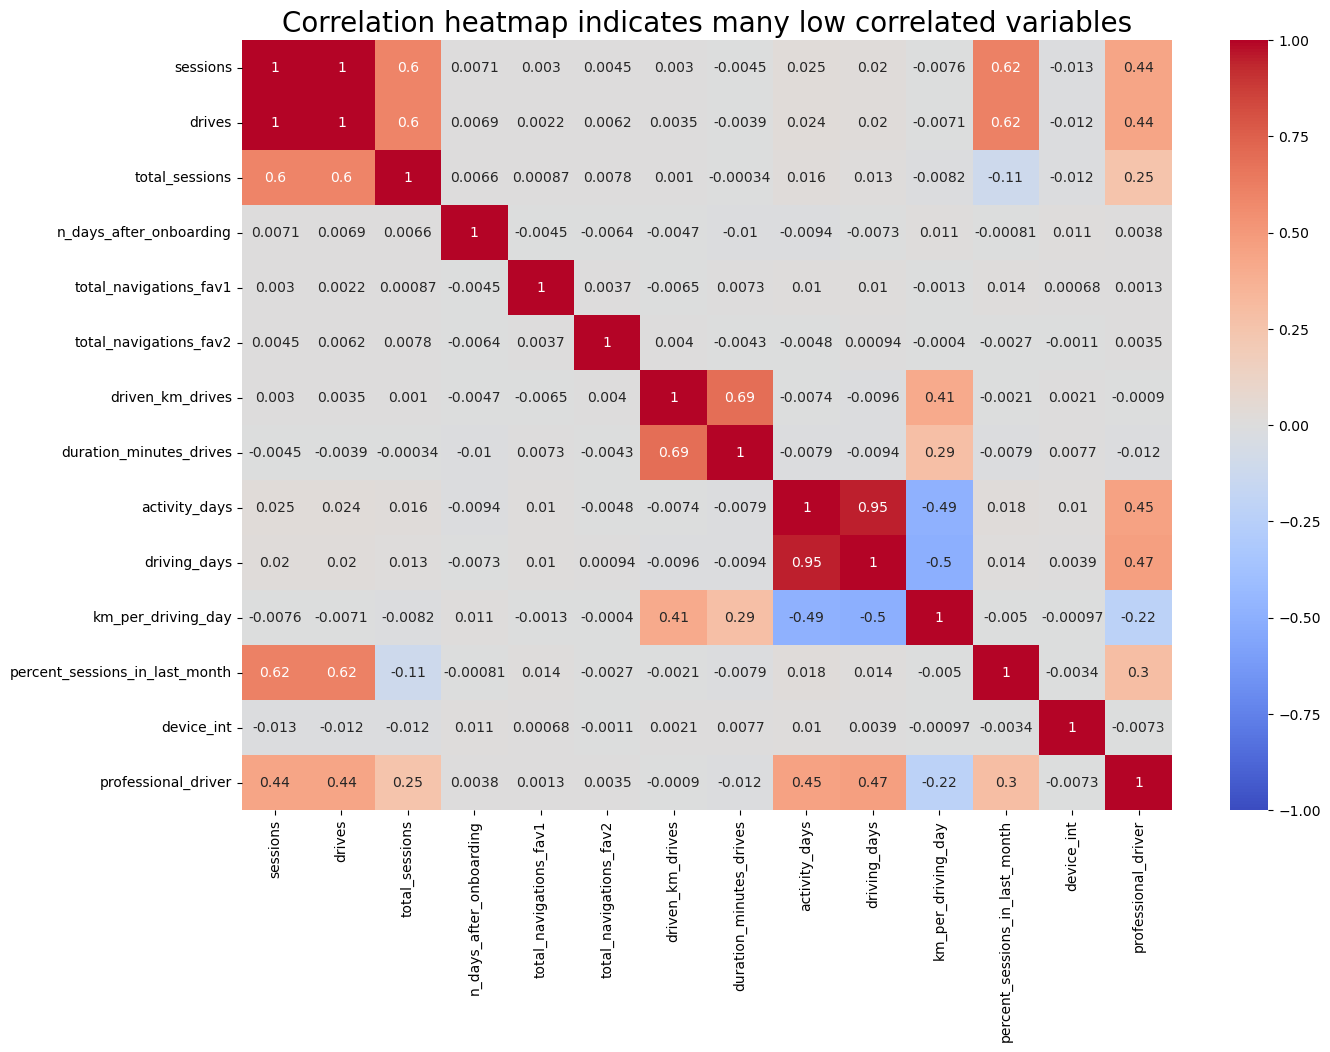

In [40]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df_corr.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=20)
plt.show();

In [62]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14299 entries, 0 to 14998
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   label                           14299 non-null  object 
 1   sessions                        14299 non-null  int64  
 2   drives                          14299 non-null  int64  
 3   total_sessions                  14299 non-null  float64
 4   n_days_after_onboarding         14299 non-null  int64  
 5   total_navigations_fav1          14299 non-null  int64  
 6   total_navigations_fav2          14299 non-null  int64  
 7   driven_km_drives                14299 non-null  float64
 8   duration_minutes_drives         14299 non-null  float64
 9   activity_days                   14299 non-null  int64  
 10  driving_days                    14299 non-null  int64  
 11  device                          14299 non-null  object 
 12  km_per_driving_day              14299

#### **Step 5c: Build and evaluate the model.**

In [76]:
# Isolate predictor variables
X = df0.drop(['label', 'label_int', 'device'], axis=1)
# Isolate target variable
y = df0['label_int']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

In [78]:
for x in [X_train, X_test]:
    print(len(x))

10724
3575


In [80]:
%%time
# Instantiate and fit the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

CPU times: total: 1.12 s
Wall time: 514 ms


LogisticRegression(max_iter=1000)

In [82]:
# Display the variable coefficients in descending order.
coefficients = pd.Series(model.coef_[0], index=X.columns)
sorted_coefficients = coefficients.abs().sort_values(ascending=False)
print(sorted_coefficients)

activity_days                     0.088676
driving_days                      0.020287
device_int                        0.007529
drives                            0.007154
sessions                          0.004352
percent_sessions_in_last_month    0.002414
total_navigations_fav2            0.001123
total_navigations_fav1            0.001053
professional_driver               0.000817
n_days_after_onboarding           0.000409
total_sessions                    0.000308
duration_minutes_drives           0.000108
km_per_driving_day                0.000061
driven_km_drives                  0.000020
dtype: float64


In [84]:
# Display the y-intercept
model.intercept_

array([-0.00439671])

##### I will call ***predict_proba()*** to generate the probability of response for each sample in the training data. The result will be assigned to the variable ***training_probabilities***. This results in a 2-D array representing observations in ***X_train***. Column 1 is the probability user retained. Column 2 is the probability of  user churned.

In [86]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.93651514, 0.06348486],
       [0.596484  , 0.403516  ],
       [0.77117921, 0.22882079],
       ...,
       [0.91401364, 0.08598636],
       [0.83791679, 0.16208321],
       [0.93836161, 0.06163839]])

In [88]:
# Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()
# Create a new `logit` column in the `logit_data` dataframe
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

##### I will plot a regplot where the x-axis represents an independent variable and the y-axis represents the log-odds of the predicted probabilities. (In an exhaustive analysis, this would be plotted for each continuous or discrete predictor variable. Here I show only **driving_days)**.

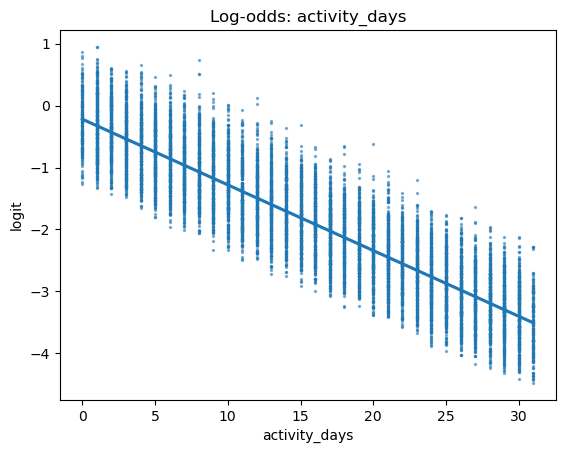

In [90]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

##### **Now let's make predictions on X_test.**

In [80]:
%%time
# Generate predictions on X_test
y_preds = model.predict(X_test)

CPU times: total: 0 ns
Wall time: 1.99 ms


In [82]:
# Score the model (default: accuracy) on the test data
print('Accuracy: ', model.score(X_test, y_test))

Accuracy:  0.8248951048951049


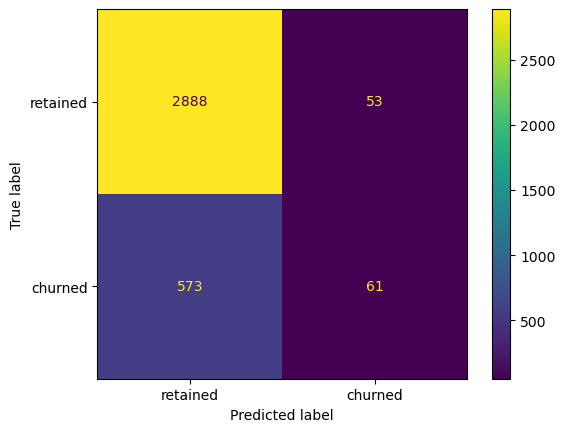

In [84]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [86]:
# Display precision, recall, and f1 score
print('Precision: ', precision_score(y_test, y_preds, pos_label=1))
print('Recall:    ', recall_score(y_test, y_preds, pos_label=1))
print('F1:        ', f1_score(y_test, y_preds, pos_label=1))

Precision:  0.5350877192982456
Recall:     0.09621451104100946
F1:         0.16310160427807488


#### **Feature Importance Report.**

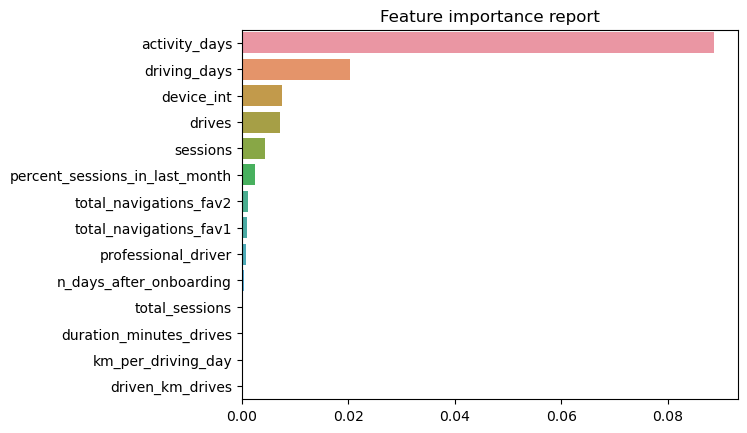

In [110]:
# Generate a feature importance report based on model coefficients..
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, abs(model.coef_[0])))
# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Plot the feature importances
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance report');

### **Step 6: Tree-bsed-modeling - Decision Tree.**

In [99]:
# Import the decision tree package
import sklearn.tree as tree

In [93]:
# Isolate predictor variables
X = df0.drop(['label', 'label_int', 'device'], axis=1)
# Isolate target variable
y = df0['label_int']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, 
    random_state=42)

In [95]:
for x in [X_train, X_test]:
    print(len(x))

10724
3575


In [101]:
# Instantiate the model
decision_tree = tree.DecisionTreeClassifier(random_state=42)
# Fit the model to training data
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [103]:
# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

In [105]:
# Print out the test scores
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))

F1 Score: 0.285
Precision: 0.275
Recall: 0.295
Accuracy: 0.737


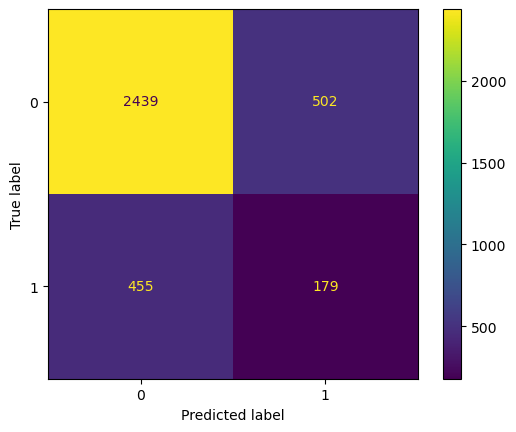

In [312]:
# Construct the confusion matrix for decision tree test data.
cm = confusion_matrix(y_test, dt_pred)
# Create the display for your confusion matrix.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decision_tree.classes_)
# Plot the visual in-line.
disp.plot()

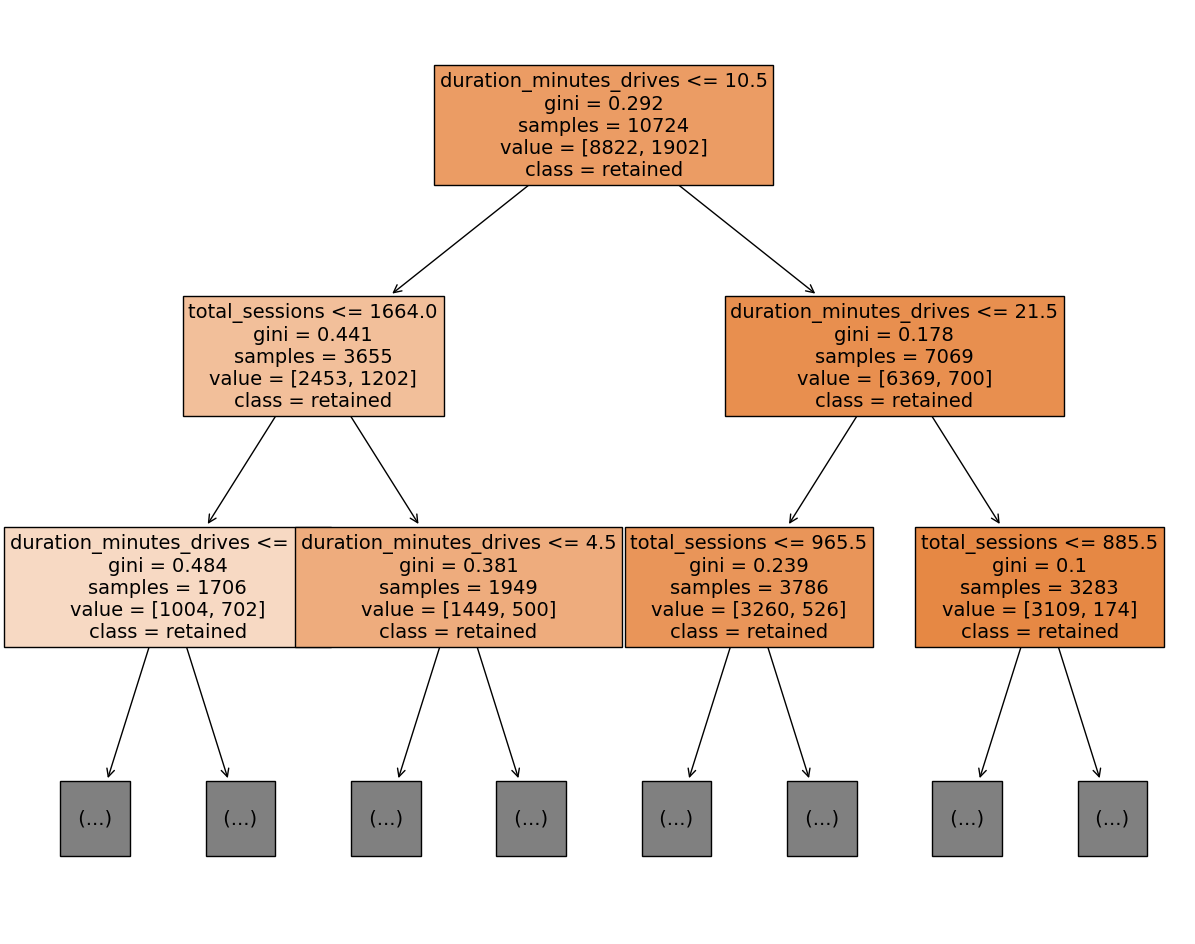

In [107]:
# Define the class_names list for plot_tree
class_names = list({0: 'retained', 1: 'churned'}.values())
plt.figure(figsize=(15,12))
tree.plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=['label', 'sessions', 
                                                                       'drives', 'total_sessions',
                                                                       'n_days_after_onboarding',  
                                                                       'total_navigations_fav1',
                                                                       'total_navigations_fav2', 
                                                                       'driven_km_drives',
                                                                       'duration_minutes_drives',
                                                                       'activity_days driving_days',
                                                                       'device',
                                                                       'km_per_driving_day'
                                                                       'percent_sessions_in_last_month',
                                                                       'professional_driver'], 
           class_names=class_names, filled=True);
plt.show()

### **Step 7: Tree-based modeling - Random Forest.**

#### **Step 7a: Additional feature engineering.**

In [117]:
# Create `total_sessions_per_day` feature
df0['total_sessions_per_day'] =  df0['total_sessions'] / df0['n_days_after_onboarding']
df0['total_sessions_per_day'].describe()

count    14299.000000
mean         0.329996
std          1.292124
min          0.000298
25%          0.050818
50%          0.100457
75%          0.208580
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [119]:
# Create `km_per_hour` feature
df0['km_per_hour'] = df0['driven_km_drives'] / (df0['duration_minutes_drives'] / 60)
df0['km_per_hour'].describe()

count    14299.000000
mean       189.443929
std        327.406274
min         72.013095
25%         92.887853
50%        121.231277
75%        191.157779
max      21800.540069
Name: km_per_hour, dtype: float64

In [123]:
# Create `km_per_drive` feature
df0['km_per_drive'] = df0['driven_km_drives'] / df0['drives']
df0['km_per_drive'].describe()

count    1.429900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.365506e+01
50%      7.429025e+01
75%      1.828194e+02
max               inf
Name: km_per_drive, dtype: float64

In [127]:
# Correct infinity values that resulted from divisw vy 0 error due to 0 values in 'drves'. 
# (Convert infinty values to 0).
df0.loc[df0['km_per_drive']==np.inf, 'km_per_drive'] = 0
# Confirm the correction
df0['km_per_drive'].describe()

count    14299.000000
mean       225.792784
std        572.402205
min          0.000000
25%         32.899109
50%         72.319628
75%        177.431844
max       8889.794236
Name: km_per_drive, dtype: float64

In [129]:
# Create `percent_of_sessions_to_favorite` feature
df0['percent_of_sessions_to_favorite'] = (
    df0['total_navigations_fav1'] + df0['total_navigations_fav2']) / df0['total_sessions']
# Get descriptive stats
df0['percent_of_sessions_to_favorite'].describe()

count    14299.000000
mean         1.679311
std          9.020891
min          0.000000
25%          0.212409
50%          0.658977
75%          1.644431
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

#### **Step 7b: Construct and evaluate random forest model .**

In [146]:
# Isolate predictor variables
X = df0.drop(['label', 'label_int', 'device'], axis=1)
# Isolate target variable
y = df0['label_int']

# Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y, test_size=0.2, 
    random_state=42)
# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr, test_size=0.25,
    random_state=42)

In [148]:
for x in [X_train, X_val , X_test]:
    print(len(x))

8579
2860
2860


In [159]:
# Custome scroing function
def custom_scoring(estimator, X, y):
    f1 = f1_score(y, estimator.predict(X))
    precision = precision_score(y, estimator.predict(X))
    recall = recall_score(y, estimator.predict(X))
    accuracy = accuracy_score(y, estimator.predict(X))
    
    return {'f1': f1, 'precision': precision, 'recall': recall, 'accuracy': accuracy}

In [164]:
%%time
# Instantiate model
rf = RandomForestClassifier(random_state=42)

# Assign dictionary of hyperparameters
cv_params = {'max_depth': [5], 
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }  

# Instantiate GridSearch
rf_cv = GridSearchCV(rf, cv_params, scoring=custom_scoring, cv=4, refit='recall')

CPU times: total: 0 ns
Wall time: 0 ns


In [166]:
%%time
rf_cv.fit(X_train, y_train) 

CPU times: total: 2min 3s
Wall time: 2min 4s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall',
             scoring=<function custom_scoring at 0x000001EA74F76660>)

In [169]:
# Examine best score
rf_cv.best_score_

0.06370527697195745

In [173]:
# Display as a dataframe the best mean test scores on rf_cv

mean_test_f1 = rf_cv.cv_results_['mean_test_f1']
f1 = mean_test_f1[0]
mean_test_precision = rf_cv.cv_results_['mean_test_precision']
precision = mean_test_precision[0]
mean_test_recall = rf_cv.cv_results_['mean_test_recall']
recall = mean_test_recall[0]
mean_test_accuracy = rf_cv.cv_results_['mean_test_accuracy']
accuracy = mean_test_accuracy[0]

table = pd.DataFrame({'model': 'rf_cv',
                          'f1': [f1],
                          'precision': [precision], 
                          'recall': [recall],
                          'accuracy': [accuracy]
                          
                         })
  
table

,model,f1,precision,recall,accuracy
0,rf_cv,0.11301,0.537495,0.063705,0.824338


#### This function extracts all the scores from a model's predictions.

In [203]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    f1 = f1_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    
    table = pd.DataFrame({'model': [model_name],
                          'f1': [f1],
                          'precision': [precision], 
                          'recall': [recall],
                          'accuracy': [accuracy]
                          
                         })
  
    return table

##### **Now I will use the function above to get the best performing model's predictions on the test set.**

In [205]:
# Get predictions on test data
rf_test_scores = get_scores('random forest test', rf_cv, X_test, y_test)
rf_test_scores

,model,f1,precision,recall,accuracy
0,random forest test,0.105634,0.491803,0.059172,0.822378


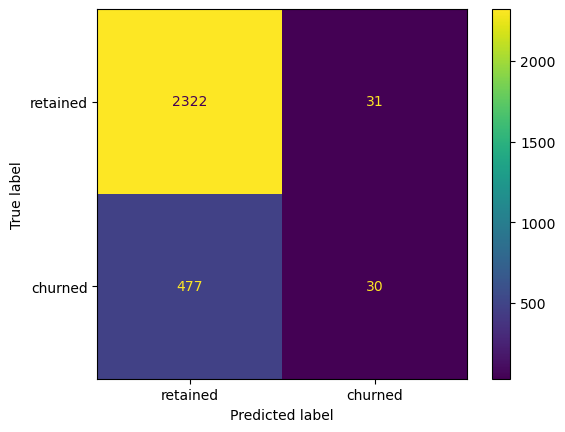

In [212]:
# Generate confusion matrix for the test data.
y_preds = rf_cv.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

#### **Feature Importance Report.**

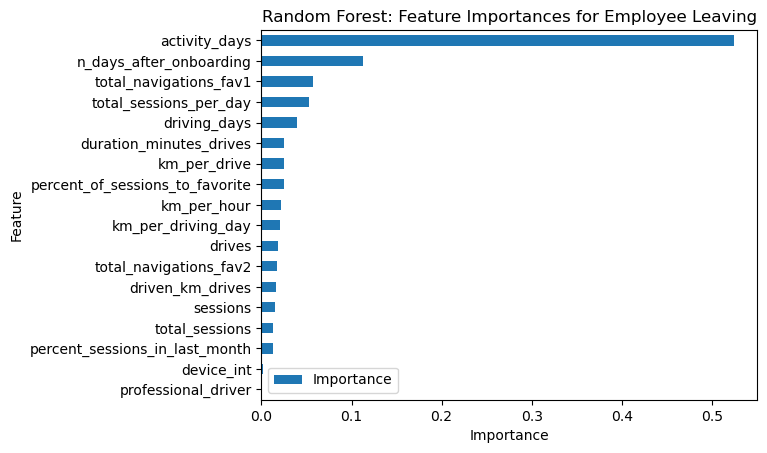

In [219]:
# Get feature importances
feat_impt = rf_cv.best_estimator_.feature_importances_

# Create feature importance report.
# Get indices of top 10 features
ind = np.argpartition(rf_cv.best_estimator_.feature_importances_, -18)[-18:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

### **PACE: Execute.**

### **Conclusin - Key Findings and Recommendations.**

#### **Key findings from this project.**
##### 1. Users who use Waze dirve a lot. Half the users drove over 3,495 kilometers (2,172 miles), and drove for over ~ 1,478 minutes (~ 25 hours) during the month.
##### 2. Roughly 83% of users stayed with the app, and about 17% of users churned.
##### 3. Median distance all users drove is ~73 kilometers. However, users who churned drove further and much more often than users who did not churn.
##### 4. Churn rate by device is roughly proportional.
#### **Reccomnedations.**
##### 1. It would be prudent to consult the data team as to why the 'driving_days' variable has a max value of 30 days, but the 'activity_days' variable has a max value of 31 days. 
##### 2. We should also ask why so many of the user sessions occurred within the last month, and why it appears so many of these sessions are from users who began using the app roughly 5 years ago (the question becomes why did so many long-term users suddenly start using the app?).  

##### 3. Of the 3 models that were constructed (logistic regression, decision tree, random forest), and based on the current iteration of the code, it appears right now the decision tree is the most successful at predicitng user churn. This is surprising. The decision tree had the best F1 and recall. However, the logistic regression had the best precision, followed closely by random forest.

##### 4. Based on this, I would not recommend any of these models to be used in a produciton environment. However, they could be used for further exploration, and can be improved upon. We could also obtain more granular data (drive times, geographic location), to further improve our predicitive model.